In [19]:
%matplotlib notebook
import os
import numpy as np
import torch 
from torch import nn 
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Part 1

The Stanford Cars dataset root directory is created below.

In [3]:
train_dir = "stanford/images/train"
val_dir = "stanford/images/val"
test_dir = "stanford/images/test"

image_size = (224,224)

normalize = tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_set = tv.datasets.ImageFolder(train_dir, tv.transforms.Compose([
    tv.transforms.Resize(image_size),
    tv.transforms.ToTensor(),
    normalize
    ]))

val_set = tv.datasets.ImageFolder(val_dir, tv.transforms.Compose([
    tv.transforms.Resize(image_size),
    tv.transforms.ToTensor(),
    normalize
    ]))

transform = tv.transforms.Compose([
    tv.transforms.Resize(image_size),
    tv.transforms.ToTensor(),
    normalize
    ])


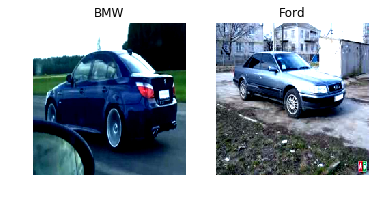

In [10]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

# Visualize images:

x = train_set[5][0]
y = train_set[200][0]
fig = plt.figure()
ax1 = fig.add_subplot(1,2,2)
myimshow(x,ax1)
plt.title("Ford")
ax2 = fig.add_subplot(1,2,1)
myimshow(y,ax2)
plt.title("BMW")
plt.show()

### Part 2 - TRAINING


In [11]:
import nntools as nt
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def criterion(self, y, d):
        return self.cross_entropy(y, d)

###  With AlexNet:

In [62]:
class AlexNetTransfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(AlexNetTransfer, self).__init__()
        alexnet = tv.models.alexnet(pretrained=True)
        for param in alexnet.parameters():
            param.requires_grad = fine_tuning
        
        self.features = alexnet.features
        self.avgpool = alexnet.avgpool 
        self.classifier = alexnet.classifier
        num_ftrs = alexnet.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        f = self.features(x)
        f = self.avgpool(f)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y

In [6]:
alexnet = tv.models.alexnet(pretrained=True)
print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/harshini/.torch/models/alexnet-owt-4df8aa71.pth
244418560it [01:12, 3392309.19it/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

### Stats Manager Set-up

In [14]:
class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
        
    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0
        
    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())
        
    def summarize(self):
        loss =super(ClassificationStatsManager, self).summarize()
        accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss': loss,'accuracy': accuracy}

In [17]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],label="training loss")
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],label="evaluation loss")
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],label="training accuracy")
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],label="evaluation accuracy")
    axes[0].legend()
    axes[1].legend()
    axes[0].set_xlabel("Epoch")
    axes[1].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[1].set_ylabel("Accuracy")
    
    plt.tight_layout()
    fig.canvas.draw()

In [67]:
lr = 1e-3
net = AlexNetTransfer(num_classes=12)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)  # With adaptive lr scheduler 
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,output_dir="carclass_axl2", perform_validation_during_training=True)

Start/Continue training from epoch 0
Epoch 1 (Time: 31.82s)
Epoch 2 (Time: 31.19s)
Epoch 3 (Time: 31.46s)
Epoch 4 (Time: 31.45s)
Epoch 5 (Time: 31.78s)
Epoch 6 (Time: 31.41s)
Epoch 7 (Time: 31.40s)
Epoch 8 (Time: 31.40s)
Epoch 9 (Time: 31.80s)
Epoch 10 (Time: 31.76s)
Epoch 11 (Time: 31.48s)
Epoch 12 (Time: 31.34s)
Epoch 13 (Time: 31.26s)
Epoch 14 (Time: 31.37s)
Epoch 15 (Time: 31.23s)
Finish training for 15 epochs


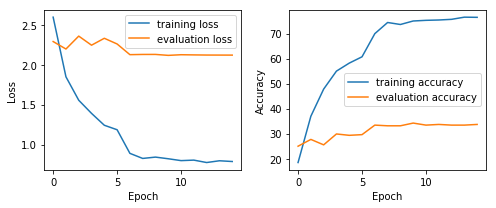

In [68]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=15, plot=lambda exp: plot(exp, fig=fig, axes=axes))

## With VGG19 Model:

In [12]:
class VGG19Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(VGG19Transfer, self).__init__()
        VGG19 = tv.models.vgg19_bn(pretrained=True)
        for param in VGG19.parameters():
            param.requires_grad = fine_tuning
        
        self.features = VGG19.features
        self.avgpool = VGG19.avgpool 
        self.classifier = VGG19.classifier
        num_ftrs = VGG19.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        f = self.features(x)
        f = self.avgpool(f)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y


In [15]:
lr = 1e-3
torch.cuda.empty_cache()
with torch.no_grad():
    net2 = VGG19Transfer(num_classes=12)
    net2 = net2.to(device)
    adam = torch.optim.Adam(net2.parameters(), lr=lr)
    stats_manager = ClassificationStatsManager()
    exp2 = nt.Experiment(net2, train_set, val_set, adam, stats_manager,output_dir="carclass1_vgg19", batch_size=10, perform_validation_during_training=True)

Start/Continue training from epoch 17
Finish training for 17 epochs


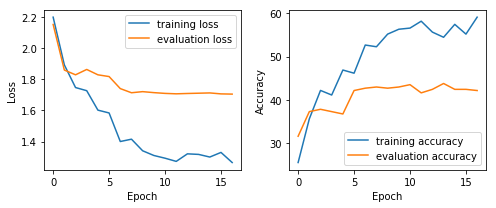

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp2.run(num_epochs=17, plot=lambda exp: plot(exp, fig=fig, axes=axes))

# TEST

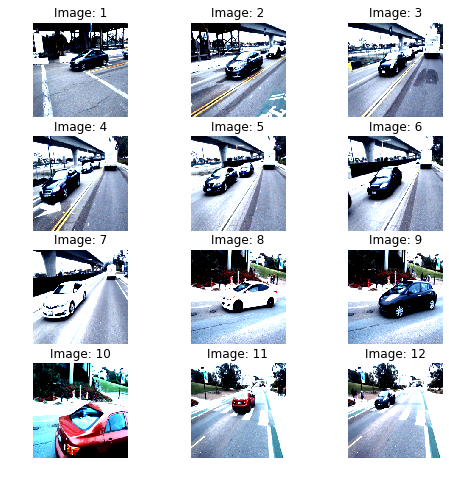

In [25]:

test_imgs = []
fig, axes = plt.subplots(ncols = 3, nrows = 4, figsize=(8,8))
for i in range(12):
    img_addr = "images (70-30)/test/*.png"
    img_addr = img_addr.replace("*", str(i+1))
    test_img = Image.open(img_addr)
    test_imgs.append(transform(test_img))
    myimshow(transform(test_img), ax=axes[int(i/3)][int(i%3)])
    axes[int(i/3)][int(i%3)].set_title("Image: {}".format(i+1))
                   

In [34]:
output = net.forward(test_imgs[-1].unsqueeze(0).cuda())  # alexnet
labels = ["Audi", "BMW", "Chevrolet", "Dodge", "Ford", "GMC", "Honda", "Hyundai", "Mercedes-Benz", "Nissan", "Toyota", "Volkswagen"]
idx = output.argmax()
print("The detected vehicle is of Make: ", labels[idx]) ## Correct label - Nissan

The detected vehicle is of Make:  Nissan


In [166]:
output = net.forward(test_imgs[1].unsqueeze(0).cuda())  # alexnet
idx = output.argmax()
print("The detected vehicle is of Make: ", labels[idx]) ##Correct label - Nissan

The detected vehicle is of Make:  Nissan


In [230]:
output = net.forward(test_imgs[6].unsqueeze(0).cuda())  # alexnet
idx = output.argmax()
print("The detected vehicle is of Make: ", labels[idx]) ##Failure Case - Toyota

The detected vehicle is of Make:  Hyundai


In [57]:
output = net2.forward(test_imgs[3].unsqueeze(0).cuda())  # alexnet
labels = ["Audi", "BMW", "Chevrolet", "Dodge", "Ford", "GMC", "Honda", "Hyundai", "Mercedes-Benz", "Nissan", "Toyota", "Volkswagen"]
idx = output.argmax()
print("The detected vehicle is of Make: ", labels[idx]) ## Correct label - VW

output = net2.forward(test_imgs[10].unsqueeze(0).cuda())  # alexnet
idx = output.argmax()
print("The detected vehicle is of Make: ", labels[idx]) ##Correct label - Toyota - 5,6

output = net2.forward(test_imgs[-1].unsqueeze(0).cuda())  # alexnet
idx = output.argmax()
print("The detected vehicle is of Make: ", labels[idx]) ##Failure Case - Nissan

The detected vehicle is of Make:  Chevrolet
The detected vehicle is of Make:  Toyota
The detected vehicle is of Make:  Toyota


In [61]:
output = net2.forward(test_imgs[1].unsqueeze(0).cuda())  # alexnet
labels = ["Audi", "BMW", "Chevrolet", "Dodge", "Ford", "GMC", "Honda", "Hyundai", "Mercedes-Benz", "Nissan", "Toyota", "Volkswagen"]
idx = output.argmax()
print("The detected vehicle is of Make: ", labels[idx]) ## Correct label - Nissan

output = net2.forward(test_imgs[-1].unsqueeze(0).cuda())  # alexnet
idx = output.argmax()
print("The detected vehicle is of Make: ", labels[idx]) ##Correct label - Nissan

output = net2.forward(test_imgs[6].unsqueeze(0).cuda())  # alexnet
idx = output.argmax()
print("The detected vehicle is of Make: ", labels[idx]) ##Correct label - Toyota

The detected vehicle is of Make:  Nissan
The detected vehicle is of Make:  GMC
The detected vehicle is of Make:  Toyota
